In [1]:
#handle warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import rasterio as rio
from rasterio.plot import show
import rasterio.mask

import copy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm

import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
lcm1990 = rio.open("data/1990/data/gb1990lcm1km_dominant.tif")
lcm2015 = rio.open("data/2015/data/lcm2015_gb_1km_dominant_target_class.img")

In [3]:
out_profile = lcm2015.profile
out_profile.update({"nodata": 0,
                    "crs": lcm1990.crs})

#https://rasterio.readthedocs.io/en/latest/topics/writing.html
with rio.Env():
    with rio.open('data/lcm2015-BNG.tif', 'w', **out_profile) as dst:
        dst.write(lcm2015.read(1),1)

In [4]:
out_profile = lcm1990.profile
out_profile.update({"nodata": 0})

with rio.Env():
    
    with rio.open('data/lcm1990-BNG.tif', 'w', **out_profile) as dst:
        dst.write(lcm1990.read(1),1) 

In [5]:
lcm1990_new = rio.open("data/lcm1990-BNG.tif")
lcm2015_new = rio.open("data/lcm2015-BNG.tif")

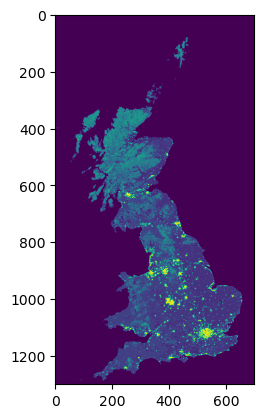

<Axes: >

In [6]:
lcm1990_newr = lcm1990_new.read(1)                       
show(lcm1990_newr, cmap='viridis')

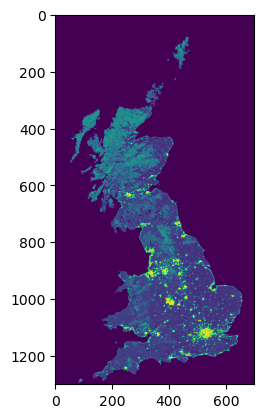

<Axes: >

In [8]:
lcm1015_newr = lcm2015_new.read(1)                       
show(lcm2015_newr, cmap='viridis')

In [9]:
lads = gpd.read_file("data/Countries_(December_2022)_GB_BUC.geojson").set_index('FID')
lads.head()

,CTRY22CD,CTRY22NM,CTRY22NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,SHAPE_Length,SHAPE_Area,geometry
FID,,,,,,,,,,,
1,E92000001,England,Lloegr,394883,370883,-2.07811,53.234970,{57FD41D4-E324-4FFD-9C8D-5E1D8BABEF68},61.013272,17.332921,"MULTIPOLYGON (((-6.34905 49.89822, -6.32842 49..."
2,S92000003,Scotland,Yr Alban,277744,700060,-3.97094,56.177429,{E6A9DD70-6152-4619-B69F-FE4059D2CBB7},130.644877,11.569044,"MULTIPOLYGON (((-3.06034 54.98452, -3.06335 54..."
3,W92000004,Wales,Cymru,263405,242881,-3.99417,52.067410,{31F21FA3-C692-4025-8DE9-82641EA2333F},21.209862,2.742505,"MULTIPOLYGON (((-4.33394 51.56503, -4.31132 51..."


In [10]:
lads_reproj  = lads.to_crs({'init': 'epsg:27700'})

In [11]:
lads_reproj_england=lads_reproj[lads_reproj['CTRY22NM']=='England']

In [12]:
lads_reproj_england.to_file("data/EnglandBoundary.geojson", driver='GeoJSON')

In [13]:
lcm1990_england, lcm1990_england_transform = rasterio.mask.mask(dataset=lcm1990_new, 
                                                            shapes=lads_reproj_england.geometry, 
                                                            crop=True)

In [14]:
lcm2015_england, lcm2015_england_transform = rasterio.mask.mask(dataset=lcm2015_new, 
                                                            shapes=lads_reproj_england.geometry, 
                                                            crop=True)

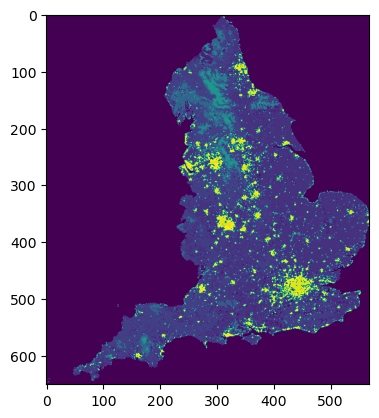

<Axes: >

In [16]:
show(lcm2015_england[0], cmap='viridis')

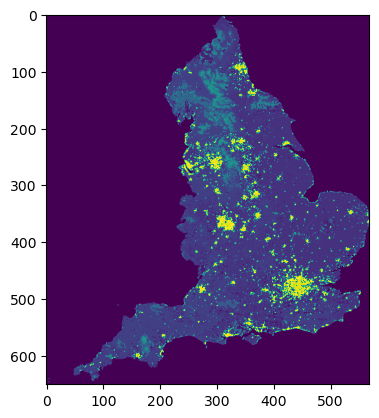

<Axes: >

In [17]:
show(lcm1990_england[0], cmap='viridis')

In [18]:
def write_nd_to_tif(nd, meta, transform, filename):
    
    #update meta from original to new data extent and transform 
    meta.update({"driver": "GTiff",
                 "height": nd.shape[1],
                 "width": nd.shape[2],
                 "transform": transform})

    with rasterio.open(filename, "w", **meta) as dest:
        dest.write(nd)

In [19]:
write_nd_to_tif(nd=lcm2015_england, 
                meta=lcm2015_new.meta, 
                transform=lcm2015_england_transform, 
                filename="data/lcm2015_england.tif")

In [20]:
write_nd_to_tif(nd=lcm1990_england, 
                meta=lcm1990_new.meta, 
                transform=lcm1990_england_transform, 
                filename="data/lcm1990_england.tif")

In [22]:
lcm1990_england = rio.open('data/lcm1990_england.tif')

lcm1990_england_np = lcm1990_england.read(1)

In [23]:
unique, counts = np.unique(lcm1990_england_np, return_counts=True)  
counts1990 = dict(zip(unique, counts))

In [24]:
print(counts1990)

{0: 240049, 1: 3762, 2: 2096, 3: 53109, 4: 48598, 5: 642, 6: 1717, 7: 4477, 8: 106, 9: 2430, 10: 688, 11: 1311, 12: 194, 13: 186, 14: 330, 15: 7, 16: 110, 17: 2, 18: 181, 19: 278, 20: 2141, 21: 8005}


In [31]:
lcm2015_england = rio.open('data/lcm2015_england.tif')

lcm2015_england_np = lcm2015_england.read(1)

In [33]:
unique, counts = np.unique(lcm2015_england_np, return_counts=True)  
counts2015 = dict(zip(unique, counts))
print(counts2015)

{0: 239839, 1: 4102, 2: 2391, 3: 54349, 4: 46206, 5: 207, 6: 553, 7: 4841, 8: 71, 9: 1757, 10: 667, 11: 1970, 12: 126, 13: 121, 14: 455, 15: 8, 16: 138, 17: 13, 18: 212, 19: 277, 20: 2578, 21: 9538}


In [34]:
original = np.ndarray(shape=(5,5), buffer=np.arange(25), dtype=int)
print(original)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


In [35]:
modified = copy.deepcopy(original)
print(modified)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


In [36]:
changes = {5: -1, 11: -3, 17: -2, 23:-4}

In [37]:
for old, new in changes.items(): 
    modified[original==old]=new
print(original)
print('\n')
print(modified)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


[[ 0  1  2  3  4]
 [-1  6  7  8  9]
 [10 -3 12 13 14]
 [15 16 -2 18 19]
 [20 21 22 -4 24]]


In [38]:
lcm2015_england6 = copy.deepcopy(lcm2015_england_np)
lcm1990_england6 = copy.deepcopy(lcm1990_england_np)

print(lcm2015_england6.shape)
print(lcm1990_england6.shape)

(651, 569)
(651, 569)


In [39]:
lookup = {1:1,2:1,
          3:2,
          4:3,5:3,6:3,7:3,8:3,9:3,10:3,11:3,16:3,18:3,19:3,
          14:4,
          20:5,21:5,
          12:6,13:6,15:6,17:6}

In [40]:
for old, new in lookup.items(): 
    lcm2015_england6[lcm2015_england_np == old]=new
    lcm1990_england6[lcm1990_england_np == old]=new

In [41]:
unique, counts = np.unique(lcm1990_england6, return_counts=True)  
counts1990_6 = dict(zip(unique, counts))                         

unique, counts = np.unique(lcm2015_england6, return_counts=True)
counts2015_6 = dict(zip(unique, counts))

print(counts1990_6)
print('\n')
print(counts2015_6)

{0: 240049, 1: 5858, 2: 53109, 3: 60538, 4: 330, 5: 10146, 6: 389}


{0: 239839, 1: 6493, 2: 54349, 3: 56899, 4: 455, 5: 12116, 6: 268}


In [43]:
lcm1990_england6_out = lcm1990_england6.reshape(1, *lcm1990_england6.shape)    
lcm2015_england6_out = lcm2015_england6.reshape(1, *lcm2015_england6.shape) 

In [44]:
write_nd_to_tif(lcm1990_england6_out,  lcm1990_new.meta, lcm1990_england_transform, "data/lcm1990_england6.tif")

write_nd_to_tif(lcm2015_england6_out, lcm2015_new.meta, lcm2015_england_transform, "data/lcm2015_england6.tif")

In [45]:
counts_df = pd.DataFrame.from_dict([counts1990_6,counts2015_6])
print(type(counts_df))
print(counts_df)

<class 'pandas.core.frame.DataFrame'>
        0     1      2      3    4      5    6
0  240049  5858  53109  60538  330  10146  389
1  239839  6493  54349  56899  455  12116  268


In [46]:
lcs = ['No Data', 'Woodland', 'Cropland', 'Grassland', 'Water', 'Built-up', 'Other'] 

lclabs = dict(zip(np.arange(0,7).tolist(), lcs))
lclabs

{0: 'No Data',
 1: 'Woodland',
 2: 'Cropland',
 3: 'Grassland',
 4: 'Water',
 5: 'Built-up',
 6: 'Other'}

In [47]:
counts_df = pd.DataFrame.from_dict([lclabs,counts1990_6,counts2015_6])
print(type(counts_df))
print(counts_df)

<class 'pandas.core.frame.DataFrame'>
         0         1         2          3      4         5      6
0  No Data  Woodland  Cropland  Grassland  Water  Built-up  Other
1   240049      5858     53109      60538    330     10146    389
2   239839      6493     54349      56899    455     12116    268


In [48]:
counts_df = pd.DataFrame.from_dict([lclabs,counts1990_6,counts2015_6]).T
print(type(counts_df))
print(counts_df)

<class 'pandas.core.frame.DataFrame'>
           0       1       2
0    No Data  240049  239839
1   Woodland    5858    6493
2   Cropland   53109   54349
3  Grassland   60538   56899
4      Water     330     455
5   Built-up   10146   12116
6      Other     389     268


In [49]:
counts_df = pd.DataFrame.from_dict([lclabs,counts1990_6,counts2015_6]).T
counts_df.columns = ['Land Cover', '1990', '2015']
counts_df

,Land Cover,1990,2015
0,No Data,240049,239839
1,Woodland,5858,6493
2,Cropland,53109,54349
3,Grassland,60538,56899
4,Water,330,455
5,Built-up,10146,12116
6,Other,389,268


In [50]:
counts_df['Diffc-9015'] = counts_df['2015'] - counts_df['1990']
counts_df

,Land Cover,1990,2015,Diffc-9015
0,No Data,240049,239839,-210
1,Woodland,5858,6493,635
2,Cropland,53109,54349,1240
3,Grassland,60538,56899,-3639
4,Water,330,455,125
5,Built-up,10146,12116,1970
6,Other,389,268,-121


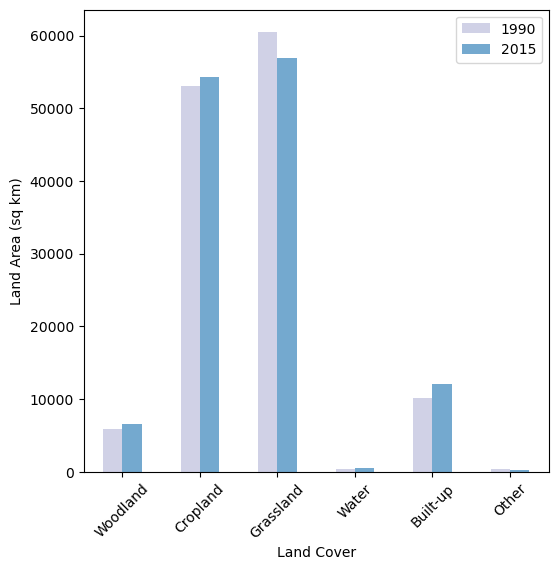

In [51]:
counts_df2 = pd.DataFrame.from_dict([lclabs,counts1990_6,counts2015_6]).T
counts_df2.columns = ['Land Cover', '1990', '2015']
counts_df2

fig, axs = plt.subplots(1, figsize=(6,6))

counts_df2[counts_df2['Land Cover']!='No Data'].plot.bar(
    ax=axs, xlabel="Land Cover", ylabel='Land Area (sq km)',
    color=['#d0d1e6', '#74a9cf', '#0570b0'])

axs.set_xticklabels(labels= lcs[1:], rotation=45)

plt.show()

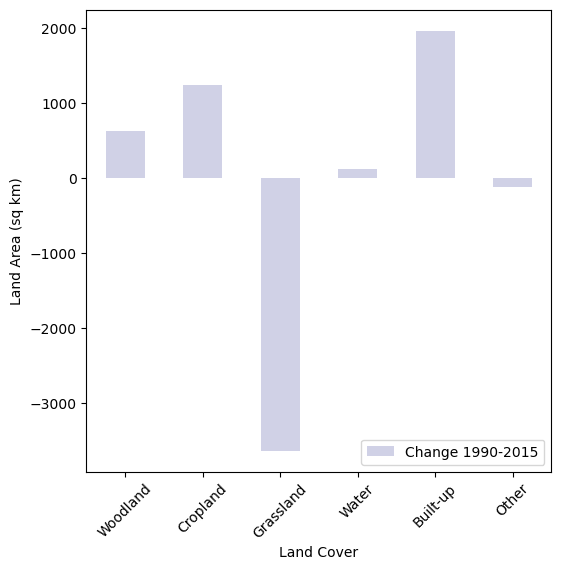

In [54]:
counts_df2['Diffc-9015'] = counts_df2['2015'] - counts_df2['1990']

fig, axs = plt.subplots(1, figsize=(6,6))

counts_df2[counts_df2['Land Cover']!='No Data'][['Diffc-9015']].plot.bar(
    ax=axs, xlabel="Land Cover", ylabel='Land Area (sq km)',
    color=['#d0d1e6', '#74a9cf'])

axs.set_xticklabels(labels= lcs[1:], rotation=45)
axs.legend(["Change 1990-2015"], loc=4);

plt.show()

In [55]:
legend_dict = {
    0: ['No Data', 'white'],
    1: ['Woodland', 'darkgreen'],
    2: ['Cropland', 'lightyellow'],
    3: ['Grassland', 'lightgreen'],
    4: ['Water', 'blue'],
    5: ['Built-up', 'black'],
    6: ['Other', 'grey'],
}

In [56]:
colors = [legend_dict[key][1] for key in sorted(legend_dict.keys())]
print(colors)
lcmap = ListedColormap(colors)
print(lcmap)

['white', 'darkgreen', 'lightyellow', 'lightgreen', 'blue', 'black', 'grey']


In [57]:
bounds = list(legend_dict.keys())
bounds.append(bounds[-1] + 1)

bnorm = BoundaryNorm(bounds, lcmap.N)

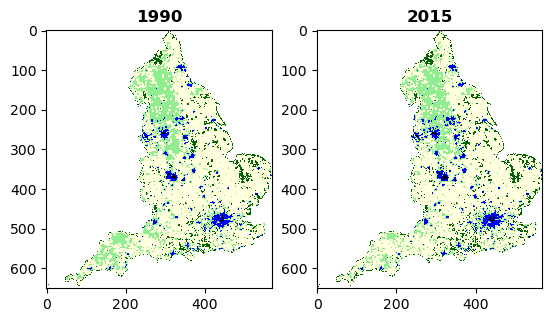

In [58]:
fig, axs = plt.subplots(1, 2)

show(source=lcm1990_england6, cmap=lcmap, norm=bnorm, title="1990", ax=axs[0])
show(source=lcm2015_england6, cmap=lcmap, norm=bnorm, title="2015", ax=axs[1])

plt.show()

In [59]:
colourboxes = [plt.Rectangle(xy=(0, 0),width=1,height=1, 
                         facecolor=legend_dict[key][1],edgecolor='black') for key in sorted(legend_dict.keys())]
lclabels = [f"{legend_dict[key][0]}" for key in sorted(legend_dict.keys())]

print(colourboxes)
print(lclabels)

[<matplotlib.patches.Rectangle object at 0x1494ab460>, <matplotlib.patches.Rectangle object at 0x1495baca0>, <matplotlib.patches.Rectangle object at 0x1380234c0>, <matplotlib.patches.Rectangle object at 0x1380231c0>, <matplotlib.patches.Rectangle object at 0x13801c370>, <matplotlib.patches.Rectangle object at 0x13802d6a0>, <matplotlib.patches.Rectangle object at 0x13802d3a0>]
['No Data', 'Woodland', 'Cropland', 'Grassland', 'Water', 'Built-up', 'Other']


NameError: name 'ax1' is not defined

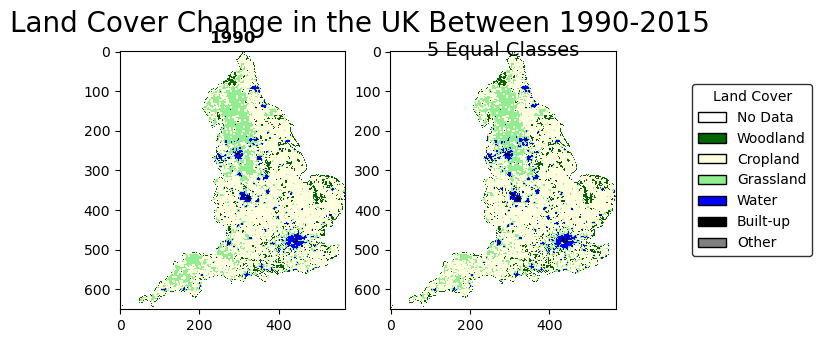

In [64]:
fig, axs = plt.subplots(1, 2)

show(source=lcm1990_england6, cmap=lcmap, norm=bnorm, title="1990", ax=axs[0])
show(source=lcm2015_england6, cmap=lcmap, norm=bnorm, title="2015", ax=axs[1])

legend = axs[1].legend(handles=colourboxes, 
                       labels=lclabels, 
                       bbox_to_anchor=(1.9, 0.9),
                      title="Land Cover",
                      edgecolor='black')



plt.suptitle('Land Cover Change in the UK Between 1990-2015', size=20, x=0.5, y=0.85) 
plt.title('5 Equal Classes', size=14, x=0.5, y=0.95)


.annotate('Source: \nUKECH (2022)',
             xy=(0.05, 0.1), xycoords='axes fraction', 
             horizontalalignment='left', verticalalignment='top', 
             fontsize=10, color='#555555')

plt.show()

ModuleNotFoundError: No module named 'pylandstats'